In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import ray
from ray import tune
from ray.train import get_context
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add project root to sys.path if it does not exist
project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# from utils.utils import create_logger
from src.data.custom_dataset import CustomDataset

In [2]:
# # colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # colab
# !pip install seaborn scikit-learn ray[tune]
# !pip install light-the-torch >> /.tmp
# !ltt install torch torchvision >> /.tmp
# !pip install fastai --upgrade >> /.tmp

In [4]:
# # colab
# from pathlib import Path
# import sys
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models, datasets, transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# import ray
# from ray import tune
# from ray.train import get_context
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

In [5]:
# # colab
# project_root = Path("/content/drive/MyDrive/car-classification-api")

# # Add project root to sys.path
# if str(project_root) not in sys.path:
#     sys.path.insert(0, str(project_root))

In [6]:
# # colab
# from src.data.custom_dataset import CustomDataset

In [7]:
train_dir = project_root / "data" / "train"

In [8]:
train_data = ImageFolder(root=str(train_dir))
class_mapping = {idx: class_name for idx, class_name in enumerate(train_data.classes)}

print(class_mapping)

{0: 'AM General Hummer SUV 2000', 1: 'Acura Integra Type R 2001', 2: 'Acura RL Sedan 2012', 3: 'Acura TL Sedan 2012', 4: 'Acura TL Type-S 2008', 5: 'Acura TSX Sedan 2012', 6: 'Acura ZDX Hatchback 2012', 7: 'Aston Martin V8 Vantage Convertible 2012', 8: 'Aston Martin V8 Vantage Coupe 2012', 9: 'Aston Martin Virage Convertible 2012', 10: 'Aston Martin Virage Coupe 2012', 11: 'Audi 100 Sedan 1994', 12: 'Audi 100 Wagon 1994', 13: 'Audi A5 Coupe 2012', 14: 'Audi R8 Coupe 2012', 15: 'Audi RS 4 Convertible 2008', 16: 'Audi S4 Sedan 2007', 17: 'Audi S4 Sedan 2012', 18: 'Audi S5 Convertible 2012', 19: 'Audi S5 Coupe 2012', 20: 'Audi S6 Sedan 2011', 21: 'Audi TT Hatchback 2011', 22: 'Audi TT RS Coupe 2012', 23: 'Audi TTS Coupe 2012', 24: 'Audi V8 Sedan 1994', 25: 'BMW 1 Series Convertible 2012', 26: 'BMW 1 Series Coupe 2012', 27: 'BMW 3 Series Sedan 2012', 28: 'BMW 3 Series Wagon 2012', 29: 'BMW 6 Series Convertible 2007', 30: 'BMW ActiveHybrid 5 Sedan 2012', 31: 'BMW M3 Coupe 2012', 32: 'BMW M5

In [9]:
# Define the directory using Path
ray_results_dir = project_root / "ray_results"

# Ensure the directory exists
ray_results_dir.mkdir(parents=True, exist_ok=True)

In [10]:
def train_resnet50(config):

    model = models.resnet50(weights='DEFAULT')

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Get all bottleneck blocks in layer4
    bottleneck_blocks = list(model.layer4.children()) # there are 3 bottleneck blocks

    # Select how many bottleneck blocks to unfreeze based on Ray Tune
    num_blocks_to_unfreeze = config["num_bottlenecks_to_unfreeze"]
    blocks_to_unfreeze = bottleneck_blocks[-num_blocks_to_unfreeze:]

    # Unfreeze all layers inside the selected bottleneck blocks
    for block in blocks_to_unfreeze:
        for param in block.parameters():
            param.requires_grad = True

    # # Always keep BatchNorm layers trainable
    # for module in model.modules():
    #     if isinstance(module, nn.BatchNorm2d):
    #         for param in module.parameters():
    #             param.requires_grad = True

    # Modify the classifier
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, config["num_classes"])

    # # COLAB - Move model to GPU if available
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model.to(device)
    # print(f"Using device: {device}")  # Check if GPU is being used

    # Move model to device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    # Data transformations
    train_transformers = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transformers = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load datasets
    train_data = datasets.ImageFolder(train_dir)

    # Extract labels
    labels = [train_data.targets[idx] for idx in range(len(train_data))]

    # Stratified split
    train_indices, val_indices = train_test_split(
        range(len(train_data)),
        test_size=0.2,
        stratify=labels,
        random_state=42
)

    # Split into train and validation datasets
    train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
    val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    # Get the TrainContext from Ray Tune
    context = get_context()

    # Access trial-specific metadata
    trial_id = context.get_trial_id() # Unique trial ID
    trial_name = context.get_trial_name()  # Human-readable trial name
    trial_dir = Path(context.get_trial_dir())  # Directory for trial-specific files

    # Training loop
    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Predictions for training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Predictions for val accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save checkpoint only if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            # Choose data to save as part of checkpoint
            checkpoint_data = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
                "config": config
            }

            # Create a unique checkpoint dir
            checkpoint_dir = trial_dir / f"checkpoint_epoch_{epoch}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)

            # Save checkpoint data to the subdirectory
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch}.pkl"
            with open(checkpoint_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)


        ray.tune.report({"train_loss": train_loss,
                        "train_accuracy": train_accuracy,
                        "val_loss": val_loss,
                        "val_accuracy": val_accuracy,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                        "val_accuracies": val_accuracies,
                        "train_accuracies": train_accuracies})

In [11]:
# ray.shutdown()  # Shut down Ray

In [12]:
# # colab 
# ray.init(runtime_env={
#     "working_dir": "/content/drive/MyDrive/car-classification-api"
#     })

In [13]:
ray.init(runtime_env={
    "working_dir": str(project_root)
    })

2025-02-04 18:24:00,475	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-04 18:24:00,599	INFO packaging.py:574 -- Creating a file package for local module '/Users/jas/Documents/car-classification-api'.
2025-02-04 18:24:00,695	INFO packaging.py:366 -- Pushing file package 'gcs://_ray_pkg_1f3374204aef59ed.zip' (35.92MiB) to Ray cluster...
2025-02-04 18:24:00,762	INFO packaging.py:379 -- Successfully pushed file package 'gcs://_ray_pkg_1f3374204aef59ed.zip'.


Python version:,3.9.21
Ray version:,2.41.0


In [14]:
# Hyperparameter tuning

search_space = {
    "lr": tune.loguniform(1e-4, 1e-2),  # Learning rate
    "batch_size": tune.choice([16, 32, 64]),  # Batch size
    "num_bottlenecks_to_unfreeze": tune.choice([1, 2]),  # Number of bottlenecks in layer 4 to unfreeze
    "num_classes": len(datasets.ImageFolder(train_dir).classes),  # Number of classes
    "epochs": 15  # Number of epochs
}

tuner = tune.Tuner(
    tune.with_resources(train_resnet50, resources={"cpu": 4}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="val_accuracy",
        mode="max", # Optimize for maximum val accuracy
        num_samples= 6, # Limit to 8 trials of random combinations of hyperparameters fr search_space
        max_concurrent_trials=1 # Run 1 trial at a time
        )
        ,
    run_config=tune.RunConfig(storage_path=str(ray_results_dir))
)

results = tuner.fit()

(train_resnet50 pid=1057) Using device: mps
(train_resnet50 pid=2142) Using device: mps
(train_resnet50 pid=2791) Using device: mps
(train_resnet50 pid=3537) Using device: mps


2025-02-04 20:01:06,536	WARNING util.py:201 -- The `on_step_begin` operation took 0.514 s, which may be a performance bottleneck.
2025-02-04 20:09:20,266	WARNING util.py:201 -- The `on_step_begin` operation took 1.236 s, which may be a performance bottleneck.
2025-02-04 20:32:48,936	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 0.619 s, which may be a performance bottleneck.
2025-02-04 20:32:48,949	WARNING util.py:201 -- The `process_trial_result` operation took 0.636 s, which may be a performance bottleneck.
2025-02-04 20:32:48,949	WARNING util.py:201 -- Processing trial results took 0.637 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-04 20:32:48,950	WARNING util.py:201 -- The `process_trial_result` operation took 0.637 s, which may be a performance bottleneck.
2025-02-04 20:49:06,789	WARNING util.py:201 -- The `on_step_begin` operation took 0.751 s, which may be a performance bottleneck.
2025-0

(raylet) [2025-02-04 20:53:47,493 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.4122 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 20:54:08,974 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.3669 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 20:54:27,314 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.353 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 20:54:45,530 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.3833 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 20:54:57

(train_resnet50 pid=4432) Using device: mps


(raylet) [2025-02-04 21:45:48,343 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.4063 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 21:46:11,558 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.4085 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 21:47:14,324 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.384 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 21:47:31,035 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 11.4033 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 21:47:55

(train_resnet50 pid=5519) Using device: mps


(raylet) [2025-02-04 22:04:16,185 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 10.9005 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 22:04:26,230 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 10.1946 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 22:04:36,266 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 10.5421 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 22:04:46,279 E 1044 9667] file_system_monitor.cc:116: /tmp/ray/session_2025-02-04_18-23-59_601325_951 is over 95% full, available space: 10.6264 GB; capacity: 228.274 GB. Object creation will fail if spilling is required.
(raylet) [2025-02-04 22:04:5

In [15]:
results

ResultGrid<[
  Result(
    metrics={'train_loss': 0.13452324802832058, 'train_accuracy': 96.5617805065234, 'val_loss': 2.0108188706285812, 'val_accuracy': 54.08225905463475, 'train_losses': [4.1444243625098585, 2.076556810853528, 1.2981837191710286, 0.8631526998737279, 0.6254753810444883, 0.47830115938011336, 0.3643738807580781, 0.28652851003240426, 0.24204588651328401, 0.22388017346498137, 0.18762846486916876, 0.17021973169518306, 0.1659536728083028, 0.1460828639226783, 0.13452324802832058], 'val_losses': [2.834722025721681, 2.2289372986438227, 1.9342608370032965, 1.7912856644275141, 1.8244833607299655, 1.760474497196721, 1.8263060298620486, 1.860305148012498, 1.7341661920734481, 1.814285194756938, 1.8580800534463395, 1.8560875870433509, 1.8705278412968505, 1.9519535256367104, 2.0108188706285812], 'val_accuracies': [29.158993247391038, 40.82259054634745, 47.0841006752609, 52.67034990791897, 51.81092694904849, 54.81890730509515, 53.16144874155924, 53.1000613873542, 56.353591160220994, 

In [16]:
for result in results:
    print(f"Trial Config: {result.config}, Validation Loss: {result.metrics['val_loss']}, Validation Accuracy: {result.metrics['val_accuracy']}")

Trial Config: {'lr': 0.0022040569418485642, 'batch_size': 16, 'num_bottlenecks_to_unfreeze': 1, 'num_classes': 196, 'epochs': 15}, Validation Loss: 2.0108188706285812, Validation Accuracy: 54.08225905463475
Trial Config: {'lr': 0.00023835124360836502, 'batch_size': 32, 'num_bottlenecks_to_unfreeze': 2, 'num_classes': 196, 'epochs': 15}, Validation Loss: 1.1857090522261227, Validation Accuracy: 68.93799877225291
Trial Config: {'lr': 0.004590185304068799, 'batch_size': 64, 'num_bottlenecks_to_unfreeze': 2, 'num_classes': 196, 'epochs': 15}, Validation Loss: 1.4515762604199922, Validation Accuracy: 64.27255985267035
Trial Config: {'lr': 0.0004991118163041968, 'batch_size': 32, 'num_bottlenecks_to_unfreeze': 1, 'num_classes': 196, 'epochs': 15}, Validation Loss: 1.581460288926667, Validation Accuracy: 59.729895641497855
Trial Config: {'lr': 0.0002161088366230479, 'batch_size': 64, 'num_bottlenecks_to_unfreeze': 1, 'num_classes': 196, 'epochs': 15}, Validation Loss: 1.4765305931751544, Vali

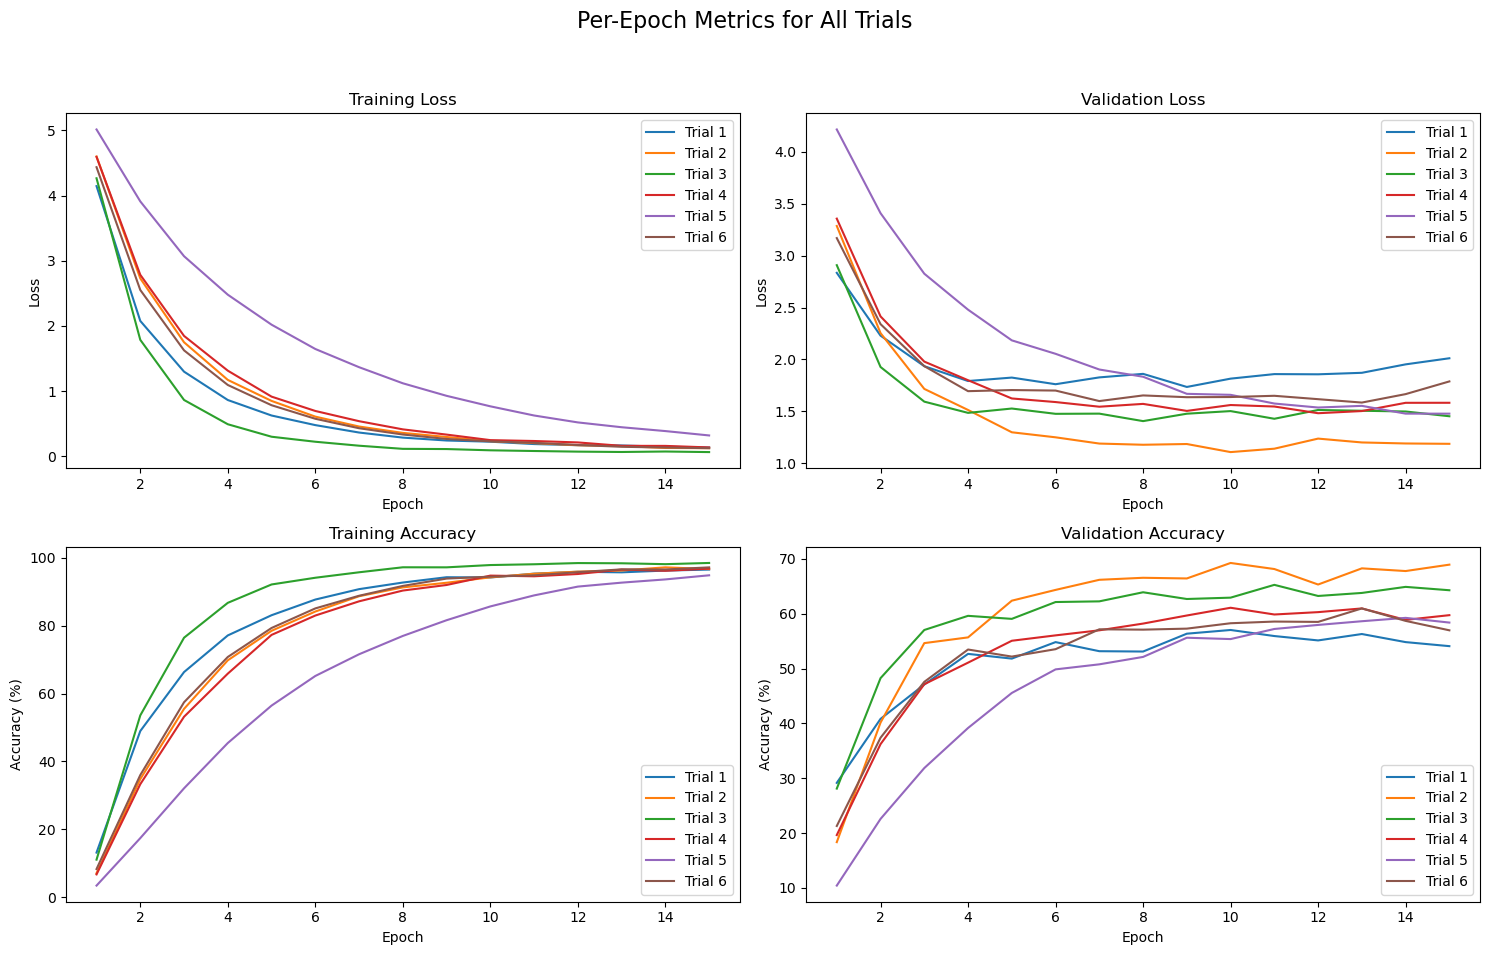

In [17]:
# Initialize plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Per-Epoch Metrics for All Trials", fontsize=16)

# Colors for distinguishing trials
colors = plt.cm.tab10.colors

# Iterate through results and plot metrics
for i, result in enumerate(results):
    metrics = result.metrics
    train_losses = metrics.get("train_losses", [])
    val_losses = metrics.get("val_losses", [])
    train_accuracies = metrics.get("train_accuracies", [])
    val_accuracies = metrics.get("val_accuracies", [])

    # Plot training losses (top-left)
    axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")

    # Plot validation losses (top-right)
    axes[0, 1].plot(range(1, len(val_losses) + 1), val_losses, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[0, 1].set_title("Validation Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")

    # Plot training accuracy (bottom-left)
    # if isinstance(train_accuracies, list):  # Check if accuracy is per epoch
    axes[1, 0].plot(range(1, len(train_accuracies) + 1), train_accuracies, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[1, 0].set_title("Training Accuracy")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy (%)")

    # Plot validation accuracy (bottom-right)
    # if isinstance(val_accuracies, list):  # Check if accuracy is per epoch
    axes[1, 1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy (%)")

# Add legends
axes[0, 0].legend(loc="upper right")
axes[0, 1].legend(loc="upper right")
axes[1, 0].legend(loc="lower right")
axes[1, 1].legend(loc="lower right")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])